In [1]:
from cil.io.utilities import HDF5_utilities
from cil.utilities.display import show2D, show_geometry
from cil.framework import AcquisitionData, AcquisitionGeometry, DataContainer
from cil.utilities.jupyter import islicer
from cil.plugins.astra.processors import FBP
from cil.processors import Normaliser, TransmissionAbsorptionConverter

import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import scipy

/home/bgb37495/miniconda3/envs/lamino/lib/python3.12/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
filepath = '/mnt/share/ALC_laminography/folder/combined_data/k11-54013.nxs'

In [3]:
HDF5_utilities.print_metadata(filepath)

	 - entry : <HDF5 group "/entry" (3 members)>
		 - imaging : <HDF5 group "/entry/imaging" (1 members)>
			 - data : <HDF5 dataset "data": shape (1519, 540, 640), type "<i4">
		 - imaging_sum : <HDF5 group "/entry/imaging_sum" (1 members)>
			 - smaract_zrot : <HDF5 dataset "smaract_zrot": shape (1519,), type "<f8">
		 - instrument : <HDF5 group "/entry/instrument" (1 members)>
			 - EtherCAT : <HDF5 group "/entry/instrument/EtherCAT" (1 members)>
				 - image_key : <HDF5 dataset "image_key": shape (1519,), type "<i4">


In [4]:
key = HDF5_utilities.read(filename=filepath, dset_path='entry/instrument/EtherCAT/image_key')

In [5]:
angles = HDF5_utilities.read(filename=filepath, dset_path='/entry/imaging_sum/smaract_zrot')

In [6]:
data = HDF5_utilities.read(filename=filepath, dset_path='/entry/imaging/data', source_sel=(key == 0,))
flat = HDF5_utilities.read(filename=filepath, dset_path='/entry/imaging/data', source_sel=(key == 1,))
dark = HDF5_utilities.read(filename=filepath, dset_path='/entry/imaging/data', source_sel=(key == 2,))

In [7]:
ag = AcquisitionGeometry.create_Parallel3D()
ag.set_angles(angles[key==0,])
ag.set_panel([data.shape[2], data.shape[1]])

data = AcquisitionData(data, geometry=ag)

In [8]:
processor = Normaliser(flat_field=flat.mean(axis=0), dark_field=dark.mean(axis=0))
processor.set_input(data)
data_norm = processor.get_output()

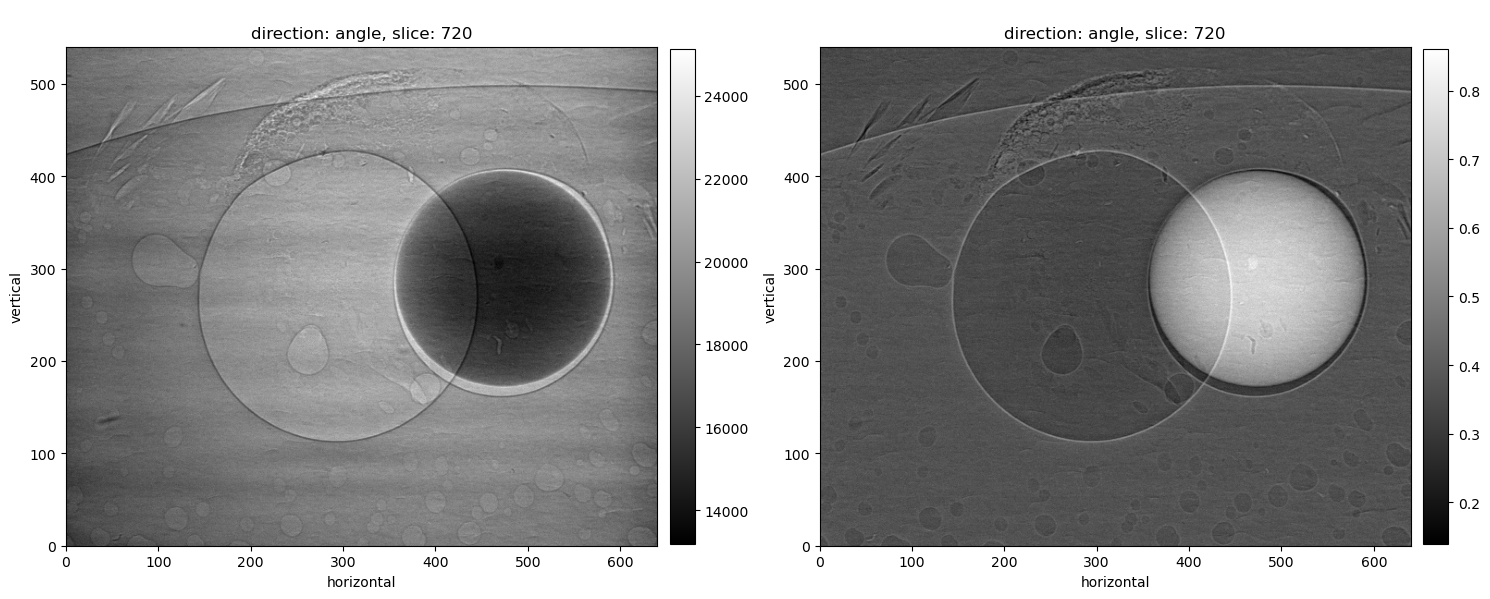

In [9]:
processor = TransmissionAbsorptionConverter()
processor.set_input(data_norm)
processor.get_output(out=data_norm)
show2D([data, data_norm])

In [10]:
islicer(data_norm)

In [11]:
data_norm.reorder('astra')
ag = data_norm.geometry
ig = ag.get_ImageGeometry()

In [12]:
data_norm.reorder('cil')

In [13]:
data_filtered = data_norm.copy()
data_filtered.fill(scipy.ndimage.sobel(data_norm.as_array(), axis=0, mode='reflect', cval=0.0))

In [14]:
islicer(data_filtered)

In [15]:
data_filtered.reorder('astra')
data_norm.reorder('astra')

In [16]:
offset = -3.3

recon_filtered_list = []
recon_list = []
tilts = np.arange(33.0, 34.5, 0.1)

evaluation = np.zeros(len(tilts))
evaluation_filtered = np.zeros(len(tilts))
for i, tilt in enumerate(tilts):
    ag_tilt = ag.copy()
    ag_tilt.set_centre_of_rotation(offset=offset)
    ag_tilt.config.system.rotation_axis.direction = [0,-np.sin(tilt), np.cos(tilt)]
    ig_tilt = ag_tilt.get_ImageGeometry()
    ig_tilt.voxel_num_z = 1

    fbp = FBP(ig_tilt, ag_tilt)
    fbp.set_input(data_filtered)
    recon_filtered = fbp.get_output()
    recon_filtered.apply_circular_mask(0.9)
    recon_filtered_list.append(recon_filtered.array)
    evaluation_filtered[i] = (recon_filtered*recon_filtered).sum()

    fbp.set_input(data_norm)
    recon = fbp.get_output()
    recon.apply_circular_mask(0.9)
    recon_list.append(recon.array)

    evaluation[i] = (recon*recon).sum()

DC_filtered = DataContainer(np.stack(recon_filtered_list, axis=0), dimension_labels=('Tilt',) + recon_filtered.geometry.dimension_labels)
DC_recon = DataContainer(np.stack(recon_list, axis=0), dimension_labels=('Tilt',) + recon.geometry.dimension_labels)

Text(0, 0.5, 'Filtered/Unfiltered normalised')

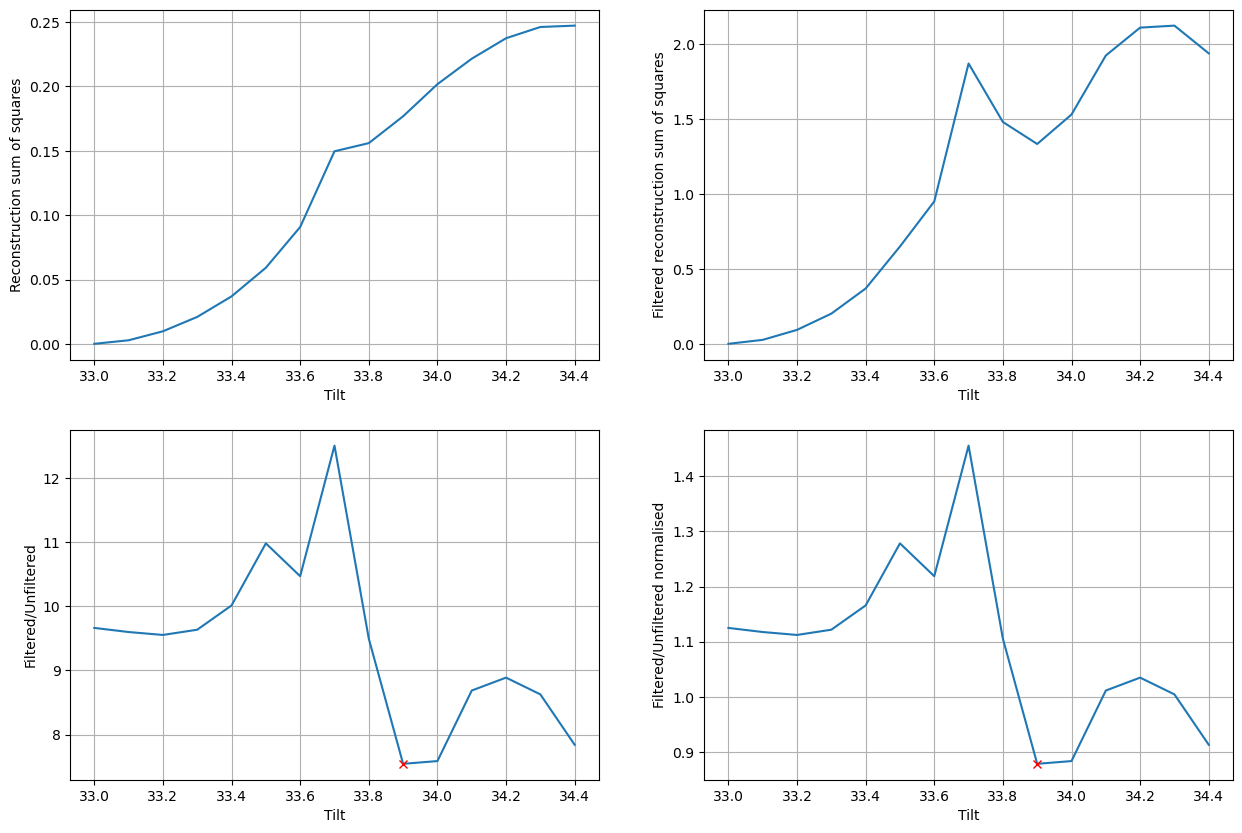

In [17]:
[fig, axs] = plt.subplots(2,2, figsize=(15,10))
ax = axs[0,0]
ax.plot(tilts, evaluation)
ax.grid()
ax.set_xlabel('Tilt')
ax.set_ylabel('Reconstruction sum of squares')

ax = axs[0,1]
ax.plot(tilts, evaluation_filtered)
ax.grid()
ax.set_xlabel('Tilt')
ax.set_ylabel('Filtered reconstruction sum of squares')

ax = axs[1,0]
y = evaluation_filtered/evaluation
ax.plot(tilts, y)
ax.plot(tilts[y.argmin()], y[y.argmin()], 'rx')
ax.grid()
ax.set_xlabel('Tilt')
ax.set_ylabel('Filtered/Unfiltered')

ax = axs[1,1]
y = (evaluation_filtered/evaluation_filtered.max())/(evaluation/evaluation.max())
ax.plot(tilts, y)
ax.plot(tilts[y.argmin()], y[y.argmin()], 'rx')
ax.grid()
ax.set_xlabel('Tilt')
ax.set_ylabel('Filtered/Unfiltered normalised')

In [18]:
islicer(DC_recon, title=tuple(['Centre of rotation offset: ' + str(t)  + ', index: ' for t in tilts]))

In [19]:
islicer(DC_filtered, title=tuple(['Centre of rotation offset: ' + str(t)  + ', index: ' for t in tilts]))

In [20]:
tilt = 34.0

recon_filtered_list_rot = []
recon_list_rot = []
offsets = [-4, -3.5, -3.4, -3.3, -3.2, -3.1, -3.0, -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2, -1.5]
evaluation_filtered_rot = np.zeros(len(offsets))
evaluation_rot = np.zeros(len(offsets))
for i, offset in enumerate(offsets):
    ag_tilt = ag.copy()
    ag_tilt.set_centre_of_rotation(offset=offset)
    ag_tilt.config.system.rotation_axis.direction = [0,-np.sin(tilt), np.cos(tilt)]
    ig_tilt = ag_tilt.get_ImageGeometry()
    ig_tilt.voxel_num_z = 1

    fbp = FBP(ig_tilt, ag_tilt)
    fbp.set_input(data_filtered)
    recon_filtered = fbp.get_output()
    recon_filtered.apply_circular_mask(0.9)
    recon_filtered_list_rot.append(recon_filtered.array)
    evaluation_filtered_rot[i] = (recon_filtered*recon_filtered).sum()

    fbp.set_input(data_norm)
    recon = fbp.get_output()
    recon.apply_circular_mask(0.9)
    recon_list_rot.append(recon.array)
    evaluation_rot[i] = (recon*recon).sum()

DC_filtered_rot = DataContainer(np.stack(recon_filtered_list_rot, axis=0), dimension_labels=('Offset',) + recon_filtered.geometry.dimension_labels)
DC_recon_rot = DataContainer(np.stack(recon_list_rot, axis=0), dimension_labels=('Offset',) + recon.geometry.dimension_labels)

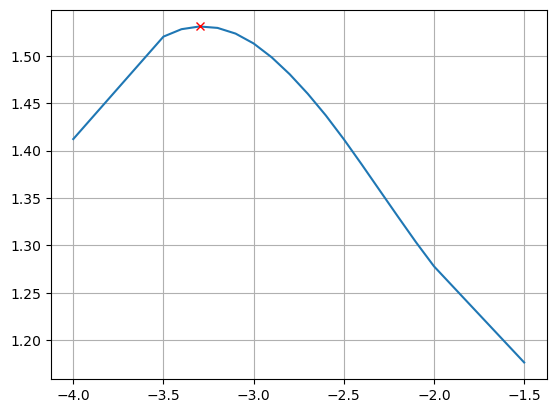

In [21]:
# plt.plot(offsets, evaluation_rot)
# plt.plot(offsets[evaluation_rot.argmax()], evaluation_rot[evaluation_rot.argmax()], 'rx')
# plt.grid()

# plt.figure()
plt.plot(offsets, evaluation_filtered_rot)
plt.plot(offsets[evaluation_filtered_rot.argmax()], evaluation_filtered_rot[evaluation_filtered_rot.argmax()], 'rx')
plt.grid()

In [22]:
offsets[evaluation_filtered_rot.argmax()]

-3.3

In [23]:
islicer(DC_recon_rot, title=tuple(['Centre of rotation offset: ' + str(t)  + ', index: ' for t in offsets]))

In [24]:
islicer(DC_filtered_rot, title=tuple(['Centre of rotation offset: ' + str(t)  + ', index: ' for t in offsets]))

In [43]:
# offset = -3.3
# tilt = 34.0

offset = -3
tilt = 34.0

ag_tilt = ag.copy()
ag_tilt.set_centre_of_rotation(offset=offset)
ag_tilt.config.system.rotation_axis.direction = [0,-np.sin(tilt), np.cos(tilt)]
ig_tilt = ag_tilt.get_ImageGeometry()

In [41]:
fbp = FBP(ig_tilt, ag_tilt)
fbp.set_input(data_norm)
recon = fbp.get_output()

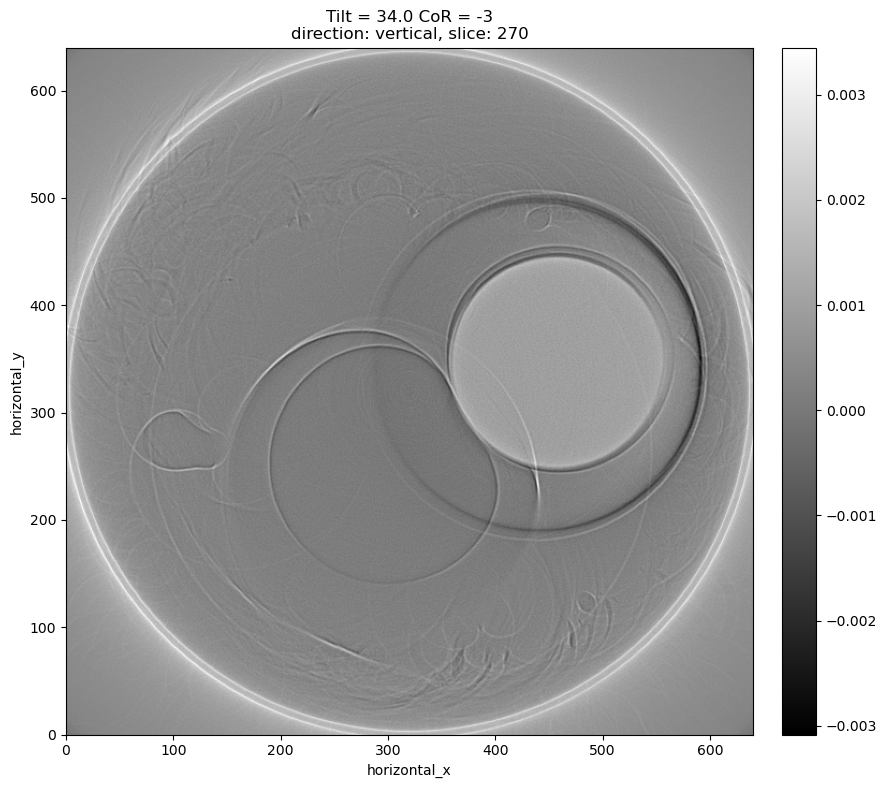

In [44]:
show2D(recon,
       title = 'Tilt = ' + str(tilt) + ' CoR = ' + str(offset))